### Setup

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import shap
from sklearn.metrics import r2_score
import featuretools as ft
from feature_engine.transformation import LogTransformer
from feature_engine.transformation import ReciprocalTransformer
import numpy as np
from openfe import OpenFE, transform
import itertools
import optuna




### Loading and inspecting data

In [15]:
df = pd.read_csv('playground-series-s4e5/train.csv', index_col = 0)
display(df.head(3))

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
id,,,,,,,,,,,,,,,,,,,,,
0,5,8,5,8,6,4,4,3,3,4,...,5,3,3,5,4,7,5,7,3,0.445
1,6,7,4,4,8,8,3,5,4,6,...,7,2,0,3,5,3,3,4,3,0.450
2,6,5,6,7,3,7,1,5,4,5,...,7,3,7,5,6,8,2,3,3,0.530


In [16]:
df.describe()

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
count,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,...,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06
mean,4.921450e+00,4.926671e+00,4.955322e+00,4.942240e+00,4.942517e+00,4.934093e+00,4.955878e+00,4.927791e+00,4.942619e+00,4.949230e+00,...,4.946893e+00,4.953999e+00,4.931376e+00,4.929032e+00,4.925907e+00,4.927520e+00,4.950859e+00,4.940587e+00,4.939004e+00,5.044803e-01
std,2.056387e+00,2.093879e+00,2.072186e+00,2.051689e+00,2.083391e+00,2.057742e+00,2.083063e+00,2.065992e+00,2.068545e+00,2.083324e+00,...,2.072333e+00,2.088899e+00,2.078287e+00,2.082395e+00,2.064813e+00,2.074176e+00,2.068696e+00,2.081123e+00,2.090350e+00,5.102610e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.850000e-01
25%,3.000000e+00,3.000000e+00,4.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,...,4.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,4.700000e-01
50%,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,...,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.050000e-01
75%,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,...,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,5.400000e-01
max,1.600000e+01,1.800000e+01,1.600000e+01,1.700000e+01,1.700000e+01,1.700000e+01,1.600000e+01,1.600000e+01,1.600000e+01,1.800000e+01,...,1.700000e+01,1.700000e+01,1.600000e+01,1.600000e+01,1.700000e+01,1.800000e+01,1.900000e+01,1.600000e+01,1.600000e+01,7.250000e-01


<Axes: >

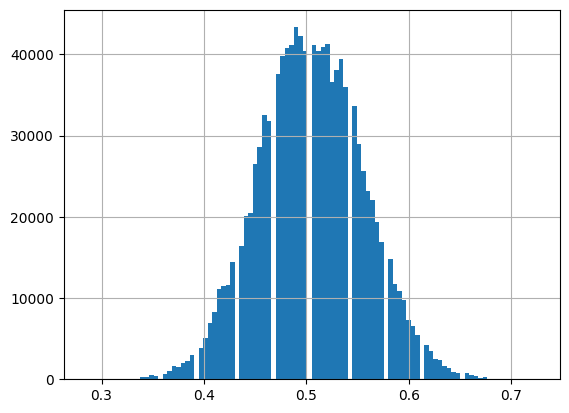

In [17]:
df['FloodProbability'].hist(bins = 100)

### Brute first model

In [9]:
X, y = df.drop('FloodProbability', axis = 1), df[['FloodProbability']]

In [10]:
X.dtypes

MonsoonIntensity                   int64
TopographyDrainage                 int64
RiverManagement                    int64
Deforestation                      int64
Urbanization                       int64
ClimateChange                      int64
DamsQuality                        int64
Siltation                          int64
AgriculturalPractices              int64
Encroachments                      int64
IneffectiveDisasterPreparedness    int64
DrainageSystems                    int64
CoastalVulnerability               int64
Landslides                         int64
Watersheds                         int64
DeterioratingInfrastructure        int64
PopulationScore                    int64
WetlandLoss                        int64
InadequatePlanning                 int64
PoliticalFactors                   int64
dtype: object

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [12]:
dtrain_reg = xgb.DMatrix(X_train, y_train)
dtest_reg = xgb.DMatrix(X_test, y_test)

In [13]:
params = {'objective':'reg:squarederror', 'tree_method':'hist'}

n = 100

model = xgb.train(
    params = params,
    dtrain = dtrain_reg,
    num_boost_round = n
)

KeyboardInterrupt: 

In [ ]:
preds = model.predict(dtest_reg)

In [ ]:
rmse = mean_squared_error(y_test, preds, squared = False)

/Users/giordan/kaggle/regression-with-a-flood-prediction-dataset/flood-prediction-venv/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
print(f'RMSE of base model: {rmse:.3f}')

RMSE of base model: 0.022


### Second iteration (adding validation sets during training)

In [ ]:
X, y = df.drop('FloodProbability', axis = 1), df[['FloodProbability']]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

dtrain_reg = xgb.DMatrix(X_train, y_train)
dtest_reg = xgb.DMatrix(X_test, y_test)

params = {'objective':'reg:squarederror', 'tree_method':'hist', 'seed':42}

n = 1000

evals = [(dtrain_reg, 'train'), (dtest_reg, 'validation')]

#for v3 increasing n = 10000
model_v2 = xgb.train(
    params = params,
    dtrain = dtrain_reg,
    num_boost_round = n,
    evals = evals,
    verbose_eval = 100
)

[0]	train-rmse:0.04899	validation-rmse:0.04899
[100]	train-rmse:0.02171	validation-rmse:0.02226
[200]	train-rmse:0.02108	validation-rmse:0.02179
[300]	train-rmse:0.02052	validation-rmse:0.02138
[400]	train-rmse:0.02018	validation-rmse:0.02119
[500]	train-rmse:0.01990	validation-rmse:0.02106
[600]	train-rmse:0.01966	validation-rmse:0.02098
[700]	train-rmse:0.01947	validation-rmse:0.02094
[800]	train-rmse:0.01930	validation-rmse:0.02091
[900]	train-rmse:0.01914	validation-rmse:0.02089
[999]	train-rmse:0.01899	validation-rmse:0.02087


In [ ]:
model_v2.get_score(importance_type='weight', )

{'MonsoonIntensity': 3596.0,
 'TopographyDrainage': 3194.0,
 'RiverManagement': 3112.0,
 'Deforestation': 2943.0,
 'Urbanization': 2986.0,
 'ClimateChange': 3034.0,
 'DamsQuality': 2998.0,
 'Siltation': 2874.0,
 'AgriculturalPractices': 2934.0,
 'Encroachments': 2976.0,
 'IneffectiveDisasterPreparedness': 2880.0,
 'DrainageSystems': 2935.0,
 'CoastalVulnerability': 3015.0,
 'Landslides': 2784.0,
 'Watersheds': 2881.0,
 'DeterioratingInfrastructure': 2951.0,
 'PopulationScore': 3001.0,
 'WetlandLoss': 2873.0,
 'InadequatePlanning': 2823.0,
 'PoliticalFactors': 2877.0}

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

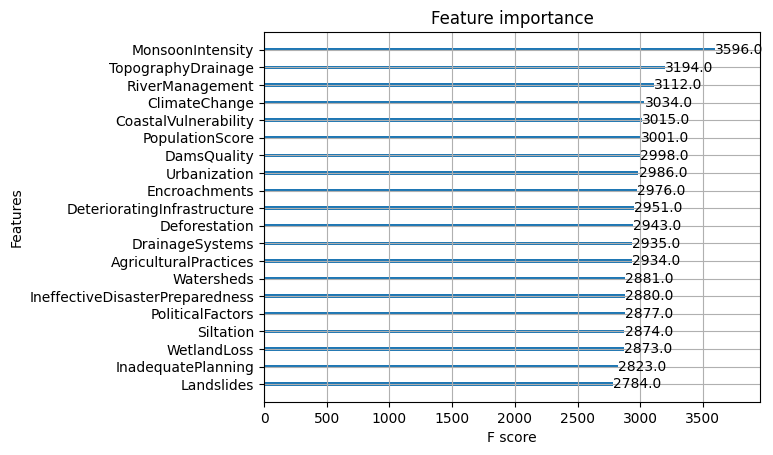

In [ ]:
xgb.plot_importance(model_v2, importance_type='weight')

In [ ]:
model_v2.save_model('xgb_regressor_v2.json')
model_v2.dump_model('xgb_regressor_v2_dump.json')

In [ ]:
y_pred = model_v2.predict(dtest_reg)

In [ ]:
dtest_reg

In [ ]:
r2 = r2_score(y_test, y_pred)

In [ ]:
print(r2)

0.8323380947113037


In [ ]:
df_test = pd.read_csv('playground-series-s4e5/test.csv', index_col = 0)
display(df_test.head(3))

dtest_2 = xgb.DMatrix(df_test)

y_pred_2 = model_v2.predict(dtest_2)


,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,IneffectiveDisasterPreparedness,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors
id,,,,,,,,,,,,,,,,,,,,
1117957,4,6,3,5,6,7,8,7,8,4,8,5,7,5,6,3,6,4,4,5
1117958,4,4,2,9,5,5,4,7,5,4,2,4,7,4,5,1,7,4,4,3
1117959,1,3,6,5,7,2,4,6,4,2,7,9,2,5,5,2,3,6,8,3


In [ ]:
y_pred_2[0:5]

array([0.5636015 , 0.45512506, 0.4577511 , 0.46626157, 0.45578966],
      dtype=float32)

In [ ]:
submission_df = pd.DataFrame({
    'id': df_test.index,  # Use the index of the test DataFrame as the 'id' column
    'FloodProbability': y_pred_2  # Use the predictions as the 'FloodProbability' column
})

# Display the first few rows to ensure it looks correct
print(submission_df.head())

submission_df.to_csv('submission_df_v1_20240522.csv', index = False)

        id  FloodProbability
0  1117957          0.563601
1  1117958          0.455125
2  1117959          0.457751
3  1117960          0.466262
4  1117961          0.455790


In [ ]:
#explainer = shap.Explainer(model_v2)
#shap_values = explainer(X)

In [ ]:
#shap.plots.waterfall(shap_values[0])

In [ ]:
#shap.plots.beeswarm(shap_values)

### V3 - Cross Validation

In [ ]:
X, y = df.drop('FloodProbability', axis = 1), df[['FloodProbability']]

dtrain_reg = xgb.DMatrix(X_train, y_train)
dtest_reg = xgb.DMatrix(X_test, y_test)

params = {'objective':'reg:squarederror', 'tree_method':'hist'}

n = 100

evals = [(dtrain_reg, 'train'), (dtest_reg, 'validation')]

model_v2 = xgb.cv(
    params = params,
    dtrain = dtrain_reg,
    num_boost_round = n,
    nfold = 5,
    metrics = {"error"},
    seed=42,
    callbacks=[xgb.callback.EvaluationMonitor(show_stdv=True)]
)

XGBoostError: [10:50:34] /Users/runner/work/xgboost/xgboost/src/metric/metric.cc:49: Unknown metric function r2_score
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000285e7c994 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000285ffc5c4 xgboost::Metric::Create(std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>> const&, xgboost::Context const*) + 124
  [bt] (2) 3   libxgboost.dylib                    0x0000000285fd21d8 xgboost::LearnerConfiguration::ConfigureMetrics(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 216
  [bt] (3) 4   libxgboost.dylib                    0x0000000285fc41c8 xgboost::LearnerConfiguration::Configure() + 1072
  [bt] (4) 5   libxgboost.dylib                    0x0000000285fc44b0 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x0000000285e9cea4 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x0000000191f97050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x0000000191f9fadc ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-39-darwin.so        0x000000010721b3ec PyInit__ctypes + 25288



In [ ]:
results.head()

NameError: name 'results' is not defined

### V4 - experimentation

In [18]:
X, y = df.drop('FloodProbability', axis = 1), df[['FloodProbability']]

In [ ]:
X.columns.tolist()

['MonsoonIntensity',
 'TopographyDrainage',
 'RiverManagement',
 'Deforestation',
 'Urbanization',
 'ClimateChange',
 'DamsQuality',
 'Siltation',
 'AgriculturalPractices',
 'Encroachments',
 'IneffectiveDisasterPreparedness',
 'DrainageSystems',
 'CoastalVulnerability',
 'Landslides',
 'Watersheds',
 'DeterioratingInfrastructure',
 'PopulationScore',
 'WetlandLoss',
 'InadequatePlanning',
 'PoliticalFactors']

In [19]:
X['features_sum'] = X.sum(axis = 1)
#X['features_mean'] = X.sum(axis = 1)

In [ ]:
X.head()

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,features_sum
id,,,,,,,,,,,,,,,,,,,,,
0,5,8,5,8,6,4,4,3,3,4,...,5,3,3,5,4,7,5,7,3,94
1,6,7,4,4,8,8,3,5,4,6,...,7,2,0,3,5,3,3,4,3,94
2,6,5,6,7,3,7,1,5,4,5,...,7,3,7,5,6,8,2,3,3,99
3,3,4,6,5,4,8,4,7,6,8,...,2,4,7,4,4,6,5,7,5,104
4,5,3,2,6,4,4,3,3,3,3,...,2,2,6,6,4,1,2,3,5,72


### Failed tests

In [ ]:
#def add_column_sums(X):
#    col_names = X.columns
#    for i in range(2, len(col_names) + 1):
#        for combo in itertools.combinations(col_names, i):
#            col_name = '_plus_'.join(combo)
#            X[col_name] = X[list(combo)].sum(axis=1)
#    return X

#X_with_sums = add_column_sums(X)

/var/folders/81/1skl1xdx06d39gl1bbt6y_240000gn/T/ipykernel_14430/3502310057.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_name] = X[list(combo)].sum(axis=1)
/var/folders/81/1skl1xdx06d39gl1bbt6y_240000gn/T/ipykernel_14430/3502310057.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_name] = X[list(combo)].sum(axis=1)
/var/folders/81/1skl1xdx06d39gl1bbt6y_240000gn/T/ipykernel_14430/3502310057.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many tim

: 

In [ ]:

#Leaving OFE for the future, current iteration took 93+ mins and crashed the kernel
#ofe = OpenFE()
#features = ofe.fit(data=X_train, label=y_train, n_jobs=4, min_candidate_features=100)  # generate new features
#train_x, test_x = transform(X_train, X_test, features, n_jobs=4) # transform the train and test data according to generated features.

In [ ]:
import optuna

def objective(trial):
    x = trial.suggest_float("x", -100, 100)
    y = trial.suggest_categorical("y", [-1, 0, 1])
    return x**2 + y

study = optuna.create_study(
    storage="sqlite:///db.sqlite3",  # Specify the storage URL here.
    study_name="quadratic-simple"
)
study.optimize(objective, n_trials=100)
print(f"Best value: {study.best_value} (params: {study.best_params})")

[I 2024-05-23 14:12:53,274] A new study created in RDB with name: quadratic-simple
[I 2024-05-23 14:12:53,339] Trial 0 finished with value: 8370.855150784395 and parameters: {'x': 91.49784232857294, 'y': -1}. Best is trial 0 with value: 8370.855150784395.
[I 2024-05-23 14:12:53,358] Trial 1 finished with value: 8114.054796159569 and parameters: {'x': 90.0780483589624, 'y': 0}. Best is trial 1 with value: 8114.054796159569.
[I 2024-05-23 14:12:53,376] Trial 2 finished with value: 9824.921565586017 and parameters: {'x': -99.12578658243281, 'y': -1}. Best is trial 1 with value: 8114.054796159569.
[I 2024-05-23 14:12:53,396] Trial 3 finished with value: 7637.665386121172 and parameters: {'x': 87.39945872899426, 'y': -1}. Best is trial 3 with value: 7637.665386121172.
[I 2024-05-23 14:12:53,418] Trial 4 finished with value: 3003.299850497546 and parameters: {'x': 54.802370847414494, 'y': 0}. Best is trial 4 with value: 3003.299850497546.
[I 2024-05-23 14:12:53,436] Trial 5 finished with val

Best value: 0.05288629943465543 (params: {'x': -0.2299702142336164, 'y': 0})


### End of failed tests

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

dtrain_reg = xgb.DMatrix(X_train, y_train)
dtest_reg = xgb.DMatrix(X_test, y_test)

In [21]:
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        'random_state': trial.suggest_int('random_state', 1, 1000)
    }
    model = xgb.XGBRegressor(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return mean_squared_error(y_test, y_pred)

In [22]:
study = optuna.create_study(
    storage="sqlite:///db.sqlite3",  # Specify the storage URL here.
    study_name="xgb-regressor-v1"
)

[I 2024-05-23 14:20:13,999] A new study created in RDB with name: xgb-regressor-v1


In [23]:
study.optimize(objective, n_trials=100)

[I 2024-05-23 14:21:03,226] Trial 0 finished with value: 0.00037708069396162944 and parameters: {'max_depth': 2, 'learning_rate': 0.7650009345486425, 'n_estimators': 661, 'min_child_weight': 9, 'gamma': 0.17935432832393614, 'subsample': 0.4627118613101735, 'colsample_bytree': 0.033480275618140126, 'reg_alpha': 0.5140897011496376, 'reg_lambda': 0.8570650179109741, 'random_state': 913}. Best is trial 0 with value: 0.00037708069396162944.
[I 2024-05-23 14:21:08,965] Trial 1 finished with value: 0.00035785353474001295 and parameters: {'max_depth': 4, 'learning_rate': 0.6483499163786551, 'n_estimators': 661, 'min_child_weight': 8, 'gamma': 0.29397873491819304, 'subsample': 0.26775076213007337, 'colsample_bytree': 0.8455633047112935, 'reg_alpha': 0.9285221456650405, 'reg_lambda': 0.09084556281633176, 'random_state': 370}. Best is trial 1 with value: 0.00035785353474001295.
[I 2024-05-23 14:21:16,195] Trial 2 finished with value: 0.00035757251120656895 and parameters: {'max_depth': 5, 'learni

In [24]:
print('Best parameters', study.best_params)

Best parameters {'max_depth': 6, 'learning_rate': 0.5897746153696071, 'n_estimators': 839, 'min_child_weight': 3, 'gamma': 0.01057118254376773, 'subsample': 0.9992361013544393, 'colsample_bytree': 0.6462090373643913, 'reg_alpha': 0.581430646970972, 'reg_lambda': 0.1818444253506821, 'random_state': 351}


In [32]:
model_v5 = xgb.XGBRegressor(**study.best_params)

model_v5.fit(X_train, y_train)

y_pred_5 = model_v5.predict(X_test)
r2 = r2_score(y_test, y_pred_5)
print(r2)

0.8663904666900635


In [34]:
df_test = pd.read_csv('playground-series-s4e5/test.csv', index_col = 0)
df_test['features_sum'] = df_test.sum(axis = 1)

dtest_5 = xgb.DMatrix(df_test)

y_pred_5_sub = model_v5.predict(df_test)

submission_df = pd.DataFrame({
    'id': df_test.index,  # Use the index of the test DataFrame as the 'id' column
    'FloodProbability': y_pred_5_sub  # Use the predictions as the 'FloodProbability' column
})

# Display the first few rows to ensure it looks correct
print(submission_df.head())

submission_df.to_csv('submission_df_v2_20240523.csv', index = False)

        id  FloodProbability
0  1117957          0.576162
1  1117958          0.451364
2  1117959          0.449833
3  1117960          0.472035
4  1117961          0.472950


In [4]:


params = {'objective':'reg:squarederror', 'tree_method':'hist', 'seed':42}

n = 1000

evals = [(dtrain_reg, 'train'), (dtest_reg, 'validation')]

model_v5 = xgb.train(
    params = params,
    dtrain = dtrain_reg,
    num_boost_round = n,
    evals = evals,
    verbose_eval = 100
)

NameError: name 'train_test_split' is not defined

#### Plot importance

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

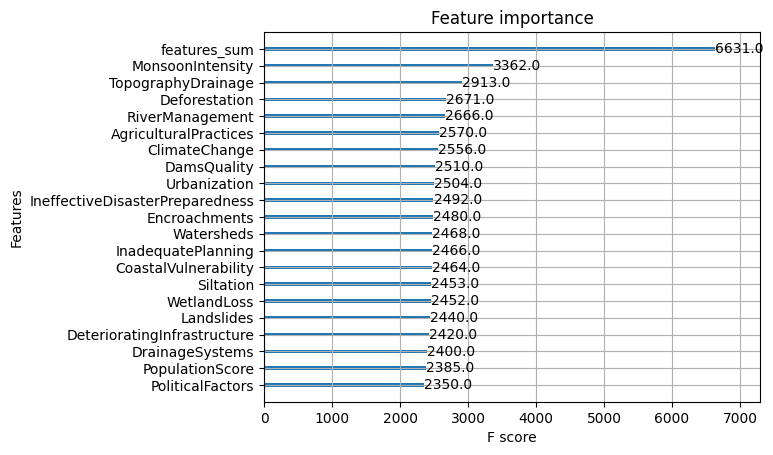

In [ ]:
xgb.plot_importance(model_v4, importance_type='weight')

In [ ]:
model_v4.get_fscore()

{'MonsoonIntensity': 3362.0,
 'TopographyDrainage': 2913.0,
 'RiverManagement': 2666.0,
 'Deforestation': 2671.0,
 'Urbanization': 2504.0,
 'ClimateChange': 2556.0,
 'DamsQuality': 2510.0,
 'Siltation': 2453.0,
 'AgriculturalPractices': 2570.0,
 'Encroachments': 2480.0,
 'IneffectiveDisasterPreparedness': 2492.0,
 'DrainageSystems': 2400.0,
 'CoastalVulnerability': 2464.0,
 'Landslides': 2440.0,
 'Watersheds': 2468.0,
 'DeterioratingInfrastructure': 2420.0,
 'PopulationScore': 2385.0,
 'WetlandLoss': 2452.0,
 'InadequatePlanning': 2466.0,
 'PoliticalFactors': 2350.0,
 'features_sum': 6631.0}

In [ ]:
model_v4.feature_names

['MonsoonIntensity',
 'TopographyDrainage',
 'RiverManagement',
 'Deforestation',
 'Urbanization',
 'ClimateChange',
 'DamsQuality',
 'Siltation',
 'AgriculturalPractices',
 'Encroachments',
 'IneffectiveDisasterPreparedness',
 'DrainageSystems',
 'CoastalVulnerability',
 'Landslides',
 'Watersheds',
 'DeterioratingInfrastructure',
 'PopulationScore',
 'WetlandLoss',
 'InadequatePlanning',
 'PoliticalFactors',
 'features_sum']

In [ ]:
y_pred = model_v4.predict(dtest_reg)
r2 = r2_score(y_test, y_pred)
print(r2)

0.8646023273468018


In [ ]:
df_test = pd.read_csv('playground-series-s4e5/test.csv', index_col = 0)

df_test['features_sum'] = df_test.sum(axis = 1)

display(df_test.head(3))


dtest_2 = xgb.DMatrix(df_test)

y_pred_3 = model_v4.predict(dtest_2)

submission_df = pd.DataFrame({
    'id': df_test.index,  # Use the index of the test DataFrame as the 'id' column
    'FloodProbability': y_pred_3  # Use the predictions as the 'FloodProbability' column
})

# Display the first few rows to ensure it looks correct
print(submission_df.head())

submission_df.to_csv('submission_df_v2_20240522.csv', index = False)

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,features_sum
id,,,,,,,,,,,,,,,,,,,,,
1117957,4,6,3,5,6,7,8,7,8,4,...,5,7,5,6,3,6,4,4,5,111
1117958,4,4,2,9,5,5,4,7,5,4,...,4,7,4,5,1,7,4,4,3,90
1117959,1,3,6,5,7,2,4,6,4,2,...,9,2,5,5,2,3,6,8,3,90


        id  FloodProbability
0  1117957          0.575805
1  1117958          0.454043
2  1117959          0.453723
3  1117960          0.470220
4  1117961          0.467739
